# Using pypardiso as an external sparse direct solver for PyFVTool

MW, 230908

This is an example of how to use an external sparse solver with PyFVTool. It is also a draft for future documentation on the subject, as part of the PyFVTool documentation.

An external solver can be supplied as an optional argument to `pyfvtool.PDEsolve()`, *e.g.*

```python
phi_new = pf.solveMatrixPDE(msh, M, RHS,
                      externalsolver = solveur)
```

where `solveur` is a function that will be called instead of `scipy.sparse.linalg.spsolve`. In this example, we use `pypardiso`.


## Install pypardiso

[`pypardiso`](https://github.com/haasad/PyPardisoProject) is a simple Python interface to the [Intel MKL PARDISO solver](https://www.intel.com/content/www/us/en/docs/onemkl/developer-reference-c/2023-2/onemkl-pardiso-parallel-direct-sparse-solver-iface.html)

Using `miniconda`/`mambaforge` with exclusively the Conda-forge repositories, `pypardiso` is readily installed (tested only on Windows 10).

```
mamba install pypardiso
```


## Test drive pypardiso

Using the example from the pypardiso README. This example is not ideal, because of the random numbers, which do not play well with the present testing infrastructure.

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pypardiso

In [2]:
pypardiso.__version__

'0.4.3'

In [3]:
A = sp.rand(10, 10, density=0.5, format='csr')

In [4]:
b = np.random.rand(10)

In [5]:
x = pypardiso.spsolve(A, b)

In [6]:
# do not output result for now.
# x

## PyFVTool finite-volume (from cylindrical2D_convection notebook)

In [7]:
from time import time
import pyfvtool as pf

#### Utility functions

In [8]:
# visualization routine (imshow-based)
def phi_visualize():
    print(f't = {t:.1f} s')
    # avoid ghost cells
    plt.imshow(phi.internalCellValues, origin = 'lower',
               extent = [zz[0], zz[-1], rr[0]*rzoom, rr[-1]*rzoom])

In [9]:
# calculate simple finite-volume integral over r
def integral_dr(phi0):
    v = phi0.domain.cellVolumes()
    c = phi0.internalCellValues
    return (v*c).sum(axis=0)

#### FVM settings

In [10]:
Lr = 7.5e-05 # [m] radius of cylinder
Lz = 0.3 # [m] length of cylinder
umax = 2*9.4314e-3 # [m s^-1] max flow velocity = 2 time average flow velocity

In [11]:
# regular grid parameters
Nr = 40
Nz = 500

In [12]:
# initial condition parameters (cell indices)
loadix0 = 20
loadix1 = 40

In [13]:
# timestep parameters
deltat = 0.01 # [s] per time step

In [14]:
# visualization parameters
rzoom = 1000

In [15]:
# SOLVER

## provide scipy.sparse.linalg.spsolve as "external" solver
# solveur = sp.linalg.spsolve 

## incompatibility of pypardiso and standard spsolve
## the following doesn't work
# solveur = pypardiso.spsolve

## quick fix, converting the csr_array to csr_matrix
## as required by pypardiso.spsolve
## TODO: open an issue in pypardiso project
##       asking for support for csr_array in pypardiso
def solveur(A, b):
    Amat = sp.csr_matrix(A) # extra matrix conversion operation
    return pypardiso.spsolve(Amat, b)

#### 2D cylindrical mesh

In [16]:
msh = pf.CylindricalGrid2D(Nr, Nz, Lr, Lz)

#### Set up Poiseuille flow velocity field

In [17]:
rr = msh.cellcenters._x
zz = msh.facecenters._y

In [18]:
uu =  umax*(1 - (rr**2)/(Lr**2)) # does not depend on zz

In [19]:
u =  pf.FaceVariable(msh, 1.0)

In [20]:
u.rvalue[:] = 0
u.zvalue[:] = uu[:, np.newaxis]

#### Solution variable

In [21]:
bc = pf.BoundaryConditions(msh)

In [22]:
phi = pf.CellVariable(msh, 0.0 , bc)

#### Initial condition

In [23]:
t=0.

In [24]:
# initial condition
for i in range(loadix0, loadix1):
    phi.value[:, i] = 1.0

t = 0.0 s


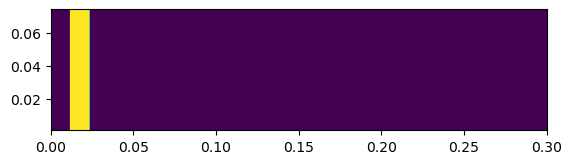

In [25]:
phi_visualize()

In [26]:
initInt = phi.domainIntegral()
# print(initInt)

In [27]:
phiprofs = []
phiprofs.append((t, integral_dr(phi)))

#### Terms with constant matrix contributions

In [28]:
# Mconv = pf.convectionTerm(u) # really ugly?
Mconv = pf.convectionUpwindTerm(u) # numerical diffusion

In [29]:
Mbc, RHSbc = pf.boundaryConditionsTerm(bc)

### Solve the convection PDE with time-stepping

In [30]:
exect0 = time()

In [31]:
def do_time_steps(Nsteps):
    global t
    for i in range(Nsteps):
        # create time-dependent matrix contributions (transientTerm)
        M_trans, RHS_trans = pf.transientTerm(phi, deltat, 1.0)
        M = M_trans + Mbc + Mconv
        RHS = RHS_trans + RHSbc
        phi_new = pf.solveMatrixPDE(msh, M, RHS,
                              externalsolver = solveur)
        phi.update_value(phi_new)
        t += deltat

In [32]:
do_time_steps(200)
phiprofs.append((t, integral_dr(phi)))

In [33]:
# print(t, initInt, pf.domainInt(phi))
# test conservation of mass
assert np.isclose(initInt, phi.domainIntegral())

t = 2.0 s


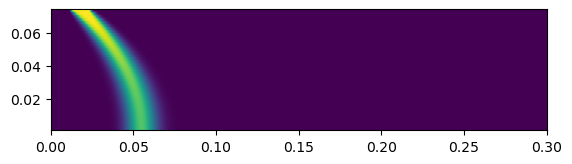

In [34]:
phi_visualize()

In [35]:
do_time_steps(300)
phiprofs.append((t, integral_dr(phi)))

In [36]:
do_time_steps(500)
phiprofs.append((t, integral_dr(phi)))

In [37]:
print(t, initInt, phi.domainIntegral())

9.999999999999831 2.1205750411731096e-10 2.120575041173027e-10


t = 10.0 s


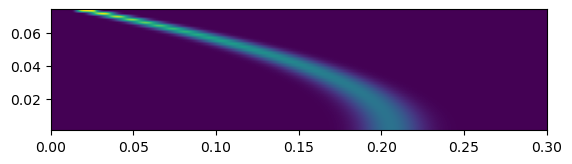

In [38]:
phi_visualize()

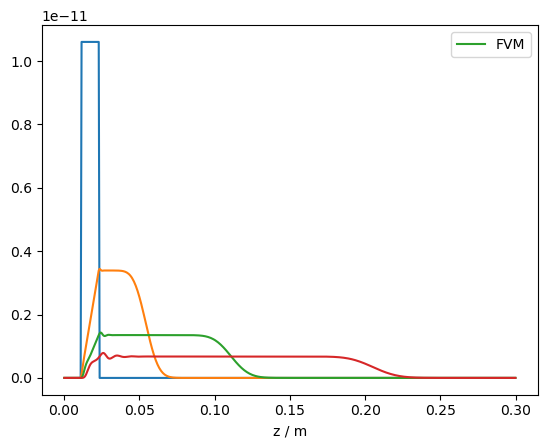

In [39]:
for ix, (tprof, phiprof) in enumerate(phiprofs):
    if ix == 2:
        lbl1 = 'FVM'
    else:
        lbl1 = None
    plt.plot(phi.domain.cellcenters._y, phiprof, 
             label=lbl1)
plt.xlabel('z / m')
plt.legend();

In [40]:
exect1 = time()

In [41]:
# print('Elapsed time ', exect1 - exect0, 's')

In [42]:
# Execution time benchmark results 
#    - Werts' computer (in 'best performance' power management mode)
#
# Elapsed time  2.36826229095459  s (pypardiso.spsolve via solveur function)
# Elapsed time  5.680087327957153 s (scipy.sparse.linalg.spsolve SuperLU)